# Using Machine Learning to Interpret the Brain

In [1]:
# import necessary libraries

import nibabel as nib
from nltools.data import Brain_Data

from nilearn import plotting
from nilearn import image
from nilearn import datasets
from nilearn import input_data
from nilearn.connectome import ConnectivityMeasure

from sklearn import metrics

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

/Users/anandafrancis/opt/anaconda3/lib/python3.8/site-packages/nilearn/datasets/__init__.py:93: FutureWarning: Fetchers from the nilearn.datasets module will be updated in version 0.9 to return python strings instead of bytes and Pandas dataframes instead of Numpy arrays.
  warn("Fetchers from the nilearn.datasets module will be "


In [8]:
def get_filename(sub, emotion, priming):
    '''
    Purpose: obtain file names from dataset folder (function must run in same directory as files)
    
    Parameters:
        sub : int
            Number of subject
            
        emotion : str
            Emotion state (anger, fear, disgust)
            
        priming : str
            Priming conditions (congruent,, incongruent, neutral)
    
    Returns: emotion state
    '''
    
    # get the subject as a string
    if sub // 10 == 0:
        sub_str = "00" + str(sub)
    
    else:
        sub_str = "0" + str(sub)
    
    # create the filename, and return
    filename = 'cp' + sub_str + '_beta_' + emotion + '_' + priming + '_c0.nii.gz'
    
    return filename

In [9]:
def create_file_list(subs, emotions, primings):
    '''
    Purpose: Create list of file names of specified subjects, emotion state and priming conditions
    
    Parameters:
        subs : list
            List of subject numbers
            
        emotions : list
            List of emotion states (anger, fear, disgust)
            
        priming : list
            List of priming conditions (congruent,, incongruent, neutral)
    
    Returns: 
    '''
    
    files = [get_filename(sub, emo, prime) for sub in subs for emo in emotions for prime in primings]
    
    return files

In [10]:
def get_class(file):
    '''
    Purpose: get the emotion state of a file based on the name of the file
    
    Parameters:
        file : str
            File name
    
    Returns: emotion state
    '''
    
    # define classes
    a = 'anger'
    d = 'disgust'
    f = 'fear'
    
    # create list of classes
    classes = [a, d, f]
    
    # iterate through list to find class
    for class_ in classes:
        if class_ in file:
            file_class = class_
    
    # output class of file
    return file_class

In [11]:
def class_list(files):
    '''
    Purpose: create list of the classes from a list of files
    
    Parameters:
        files : list
            List of file names
    
    Returns: list of class names
    '''
    classes = [get_class(file) for file in files]
    
    return classes

In [12]:
# create variables to represent all subjects, emotion states and priming conditions
subs = list(range(1, 31))
emotions = ['anger', 'disgust','fear']
primings = ['congruent', 'incongruent', 'neutral']

In [14]:
# create list of files for each priming condition 
c_brain_imgs = create_file_list(subs, emotions, ['congruent'])
i_brain_imgs = create_file_list(subs, emotions, ['incongruent'])
n_brain_imgs = create_file_list(subs, emotions, ['neutral'])

# create list of classes for each dataset (i am separating the entire 
# dataset into 3 based on priming conditions)
n_classes = class_list(n_brain_imgs)
i_classes = class_list(i_brain_imgs)
c_classes = class_list(c_brain_imgs)

# create list of files for each class (across all 3 datasets)
a_brain_imgs = create_file_list(subs, ['anger'], primings)
d_brain_imgs = create_file_list(subs, ['disgust'], primings)
f_brain_imgs = create_file_list(subs, ['fear'], primings)

In [15]:
def plot_sub_emotion(sub, emotion, coordinates = (0, 0, 0)):
    '''
    Purpose: obtains subject and emotion and plots the
    brain under the 3 different priming conditions
    
    Parameters:
        sub : int
            Number of subject
        
        emotion : str
            Name of emotion = 'anger', 'fear', 'disgust'
            
        coordinates : tuple (optional, default = (0, 0, 0))
            X, Y and Z values for plot 
    
    Returns: none, just renders 3 plots
    '''
    
    sub_emotion_c = get_filename(sub, emotion, 'congruent')
    sub_emotion_i = get_filename(sub, emotion, 'incongruent')
    sub_emotion_n = get_filename(sub, emotion, 'neutral')

    
    title_base = 'Sub ' + str(sub) + ' ' + emotion
    
    n_title = title_base + ' x neutral'
    c_title = title_base + ' x congruent'
    i_title = title_base + ' x incongruent'
    
    plotting.plot_roi(sub_emotion_c, title = c_title, cut_coords = coordinates, black_bg=True)
    plotting.plot_roi(sub_emotion_i, title = i_title, cut_coords = coordinates, black_bg=True)
    plotting.plot_roi(sub_emotion_n, title = n_title, cut_coords = coordinates, black_bg=True)

/Users/anandafrancis/opt/anaconda3/lib/python3.8/site-packages/nilearn/plotting/img_plotting.py:341: FutureWarning: Default resolution of the MNI template will change from 2mm to 1mm in version 0.10.0
  anat_img = load_mni152_template()


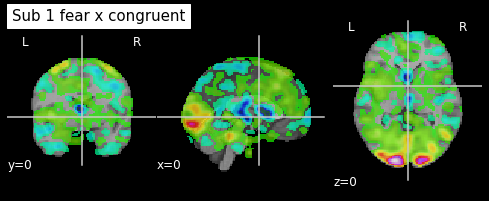

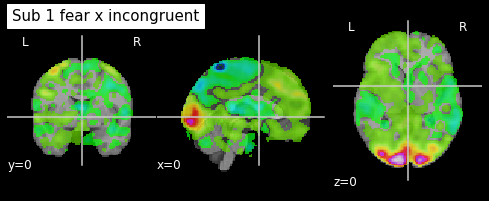

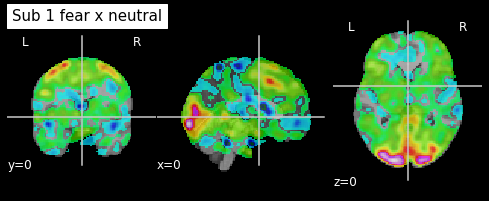

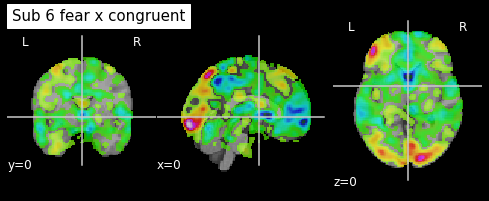

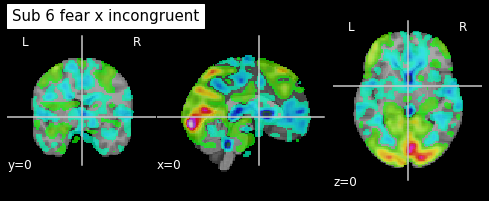

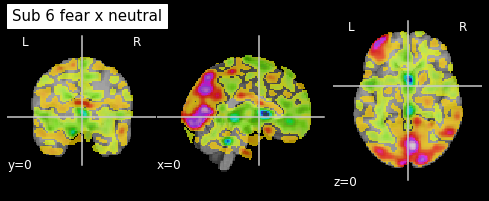

In [16]:
# Plot two random participants' brains experiencing fear
plot_sub_emotion(1, 'fear')
plot_sub_emotion(6, 'fear')

I created these initial visualizations to orient ourselves with the brain data with which I are working, and to compare differences between each subject's brain under different priming conditions, as well as compare differences between different subjects' brains. More analysis of these images is present in our report. I saw that there are differences in brain activity both across different priming conditions and also across subjects.

These findings lead us to our research questions:

Which emotional state (class) can be most accurately predicted across the different priming conditions?
How does the priming condition (incongruent, neutral, or congruent) affect the accuracy of our classifiers?
Are some similarity metrics more successful for classification than others?

## Hypothesis

To predict which emotional state would be most accurately be predicted amongst the different priming conditions I decided to take all the images belonging to each class and create an average numpy array which I then converted into an average vector (leaving us with 3 average vectors). For each vector I calculated the euclidean distance and cosine similiarity between the other 2 vectors (which I then visualized into a heatmap) with the hopes that this preliminary visualization may give us some indicator as to which emotional state would be most varying from the others (which I believed would indicate that it would be most accurately predicted).

In [17]:
# create distance metrics for kNN classifier
def euclidean(p1, p2):
    '''
    Purpose: Euclidean distance measure
    
    Parameters:
        p1 : list
            Vector 1
            
        p2 : list
            Vector 2
        
    Returns: euclidean distance 
    '''
    
    return sum([(x1-x2)**2 for x1,x2 in zip(p1,p2)]) ** 0.5

In [18]:
def mag(v):
    '''
    Purpose: calculate magnitude of a vector
    
    Parameters:
        v : list
            Vector
        
    Returns: magnitude of vector
    '''
    return sum([i **2 for i in v]) ** 0.5

In [19]:
def dot(u,v):
    '''
    Purpose: calculate dot product of two vectors
    
    Parameters: 
        u : list
            Vector 1
        v : list
            Vector 2
        
    Returns: dot product of the 2 vectors
    '''
    return sum([ui * vi for ui, vi in zip(u,v)])

In [20]:
def cosine_similarity(u, v):
    '''
    Purpose: calculate cosine similiarity between vectors
    
    Parameters:
        u : list
            Vector 1
        v : list
            Vector 2
    
    Returns: costine similarity between the 2 vectors
    '''
    
    cos_theta = dot(u,v)/(mag(u) * mag(v))
    return cos_theta

In [21]:
def avg_array(files):
    '''
    Purpose: create an average array for input class
    
    Parameters:
        files : list
            List of file names 
    
    Returns: single mean array of all average arrays 
    '''
    
    # transfer image to 2D array
    arrays = [(image.get_data(file).reshape(637, 1417)) for file in files]   
    avg_array = np.mean(np.array(arrays), axis=0)
            
    return avg_array

In [22]:
def arr_2d_to_vec(array_2D):
    '''
    Purpose: Convert a reshaped 2-dim NiLearn Image Array into a 1-dim Vector
    
    Parameters:
        array_2D : numpy array
            2-Dim array representing brain image 
    
    Returns: 1-dim vector 
    '''

    v = [array_int for array in array_2D for array_int in array]
   
    return v

In [24]:
# create an avg array for each class of brain images
a_avg_array = avg_array(a_brain_imgs)
d_avg_array = avg_array(d_brain_imgs)
f_avg_array = avg_array(f_brain_imgs)

# create list of average array for each class
avg_arrays = [a_avg_array, d_avg_array, f_avg_array]

# create list of vectors for each average array
avg_vecs = [arr_2d_to_vec(array) for array in avg_arrays]

In [36]:
def create_heatmap(dim, func, data, title, xlabels, ylabels, cmap='coolwarm'):
    '''
    Purpose: create a heatmap
    
    Parameters:
        dim : tuple
            X and Y dimensions of heatmap
            
        func : function name
            Function applied to create values inserted into numpy array
            later represented as a box in the heatmap
            
        data : list
            Data that function will be applied to
            
            
        title : str
            Title of the heatmap
            
        labels : list
            List of strings that describes data to provide accurate labels
            for heatmap
            
        cmap : str
            Color map used for heatmap
    
    Returns: none, renders a heatmap visualization
    '''
    
    # intialize
    simarray = np.zeros((dim, dim), dtype=float)

    # input values in array
    for i in range(dim):
        for j in range(dim):
            simarray[i,j] = func(data[i], data[j])

    # plot array as heatmap 
    plt.figure(dpi=150)
    heat_map = sns.heatmap(simarray, cmap=cmap, annot=True, fmt='g')
    plt.title(title)
    heat_map.set_xticklabels(xlabels, rotation=90) 
    heat_map.set_yticklabels(ylabels, rotation=0) 
    plt.show()

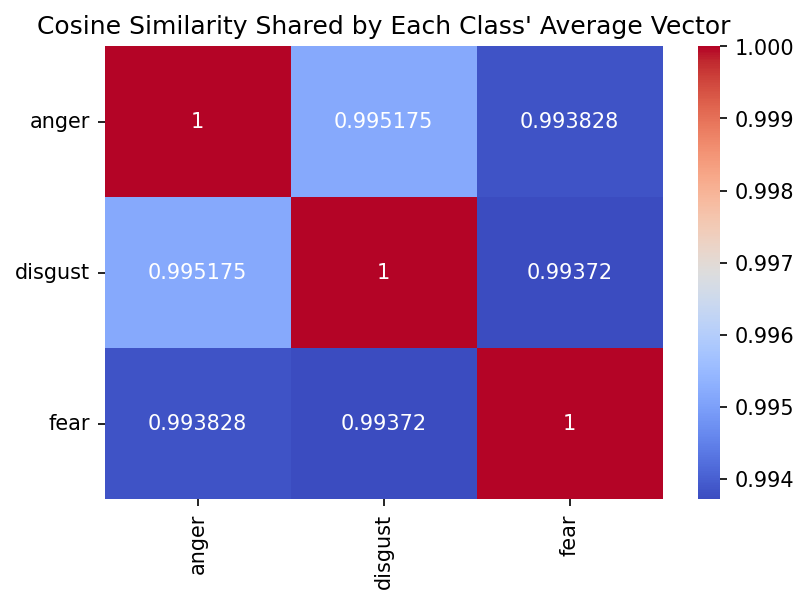

In [37]:
create_heatmap((len(avg_vecs), len(avg_vecs)), cosine_similarity, avg_vecs, 
               "Cosine Similarity Shared by Each Class' Average Vector", emotions, emotions)

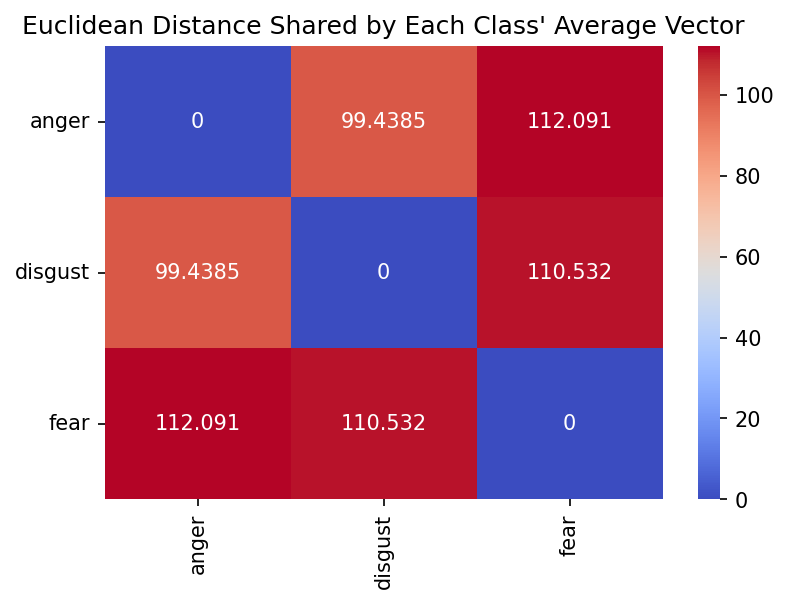

In [38]:
create_heatmap((len(avg_vecs), len(avg_vecs)), euclidean, avg_vecs, "Euclidean Distance Shared by Each Class' Average Vector", 
               emotions, emotions)

These heatmaps are very limited in terms of usefulness. I quickly realized that the lack of variance in the results (for example all the cosine similarities being very close to .999) is because I was using vectors of over 900,000 values. I decided for the rest of this project to only use arrays from parcellized brain images that consist of only 39 values that will make my analysis more meaningful. Nonetheless because fear had the highest euclidean distance and lowest cosine similarity I predict that this emotional state will be most accurately predicted amongst the different priming conditions.


I will use these mean images below to determine which brain image stands out the most across all the other mean brain images. It would make sense that the emotion x priming condition that stands out the most against the rest would have the best performance in our classifier.

In [32]:
def plot_mean_imgs(subs, primings, emotions, coordinates = (0, 0, 0)):
    '''
    Parameters:
    
        subs : list
            Number of subjects to include in mean image
            
        primings : list
            List of priming conditions (congruent, incongruent, neutral)
        
        emotions : list
            List of emotion states (anger, disgust, fear)
            
        coordinates : tuple (optional, default = (0, 0, 0))
            X, Y and Z values for plot
            
    Returns:
        None, just renders mean img plots
    '''
    
    for prime in primings:
        for emo in emotions:
            images = create_file_list(subs, [emo], [prime])
            mean_image = image.mean_img(images)
            title = emo + ' ' + prime + ' mean image of subjects '+ str(min(subs)) + ' to ' + str(max(subs))
            plotting.plot_roi(mean_image, title= title, cut_coords = coordinates, black_bg= True)

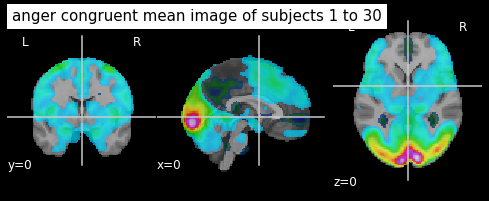

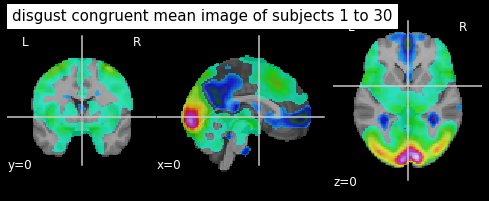

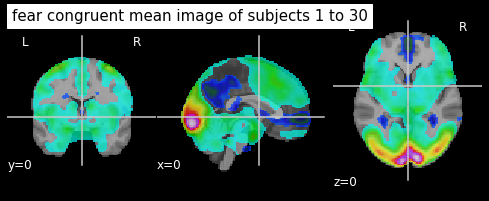

In [33]:
plot_mean_imgs(subs, ['congruent'], emotions)

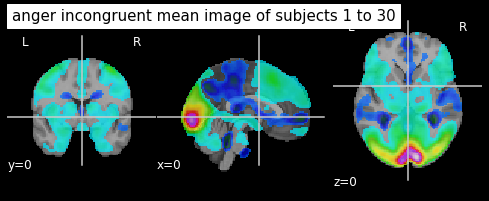

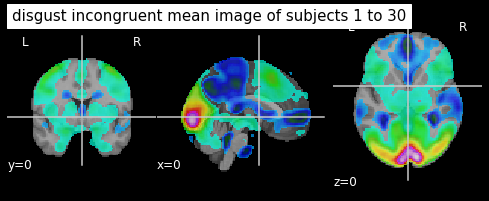

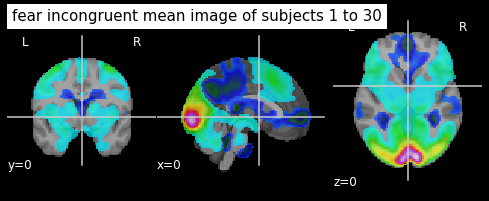

In [34]:
plot_mean_imgs(subs, ['incongruent'], emotions)

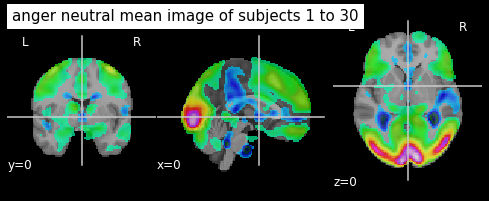

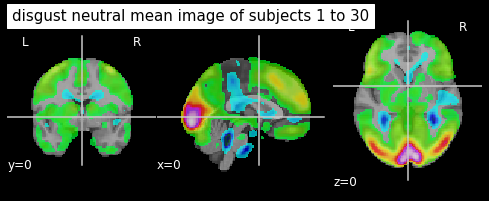

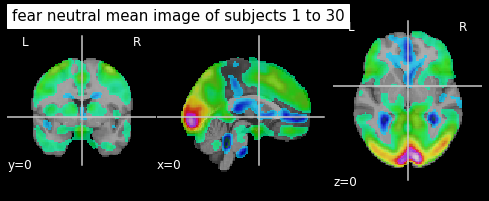

In [35]:
plot_mean_imgs(subs, ['neutral'], emotions)

/Users/anandafrancis/opt/anaconda3/lib/python3.8/site-packages/numpy/lib/npyio.py:2407: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  output = genfromtxt(fname, **kwargs)
/Users/anandafrancis/opt/anaconda3/lib/python3.8/site-packages/nilearn/plotting/displays.py:101: UserWarning: No contour levels were found within the data range.
  im = getattr(ax, type)(data_2d.copy(),


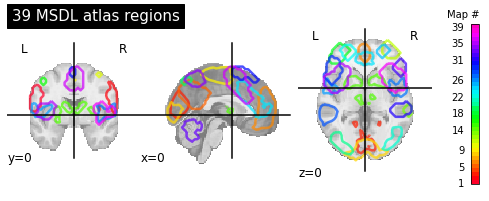

In [40]:
# Downloads atlas from nilearn dataset
msdl_atlas = datasets.fetch_atlas_msdl()
atlas_file = msdl_atlas.maps

# Shows atlas regions
plotting.plot_prob_atlas(atlas_file, cut_coords = (0,0,0), colorbar = True, title = '39 MSDL atlas regions')
    

# Saves location coordinates for each region
msdl_coords = msdl_atlas.region_coords

# The number of regions is equal to the length of coordinates output
n_regions = len(msdl_coords)

# Clean text to show brain regions represented in atlas
brain_rgns = [brain_regn.decode("utf-8") for brain_regn in msdl_atlas.networks]
brain_rgns = np.unique(brain_rgns)

In [41]:
def create_brain_array(brain_img):
    '''
    Parameters:
        brain_img : str or list
            File name or list of file names
    
    Returns: np array
        2-dim array, each value is the average brain activity intensity level of each brain region  
    '''

    # use nifti maps attribute for less strict, overlapping regional boundaries
    masker = input_data.NiftiMapsMasker(msdl_atlas.maps, resampling_target = 'data', 
                                        t_r = 2, detrend = True).fit()

    # create array of voxel intensity based brain parcellation 
    roi_vals = masker.transform(brain_img)
    
    return roi_vals

In [42]:
def create_p_vec_list(brain_imgs):
    '''
    Purpose: create list of vectors representing each file/image in list of files/images
    
    Parameters:
        brain_imgs : list
            List of files/images
    
    Returns: list of lists
    '''
    
    vecs = [arr_2d_to_vec(create_brain_array(img)) for img in brain_imgs]
    return vecs

In [43]:
# create list of vectors for each priming condition
c_vecs = create_p_vec_list(c_brain_imgs)
i_vecs = create_p_vec_list(i_brain_imgs)
n_vecs = create_p_vec_list(n_brain_imgs)

/Users/anandafrancis/opt/anaconda3/lib/python3.8/site-packages/nilearn/image/image.py:1106: FutureWarning: The parameter "sessions" will be removed in 0.9.0 release of Nilearn. Please use the parameter "runs" instead.
  data = signal.clean(
/Users/anandafrancis/opt/anaconda3/lib/python3.8/site-packages/nilearn/signal.py:198: UserWarning: Detrending of 3D signal has been requested but would lead to zero values. Skipping.
  warnings.warn('Detrending of 3D signal has been requested but '
/Users/anandafrancis/opt/anaconda3/lib/python3.8/site-packages/nilearn/image/image.py:1106: FutureWarning: The parameter "sessions" will be removed in 0.9.0 release of Nilearn. Please use the parameter "runs" instead.
  data = signal.clean(
/Users/anandafrancis/opt/anaconda3/lib/python3.8/site-packages/nilearn/signal.py:198: UserWarning: Detrending of 3D signal has been requested but would lead to zero values. Skipping.
  warnings.warn('Detrending of 3D signal has been requested but '
/Users/anandafrancis

/Users/anandafrancis/opt/anaconda3/lib/python3.8/site-packages/nilearn/signal.py:198: UserWarning: Detrending of 3D signal has been requested but would lead to zero values. Skipping.
  warnings.warn('Detrending of 3D signal has been requested but '
/Users/anandafrancis/opt/anaconda3/lib/python3.8/site-packages/nilearn/image/image.py:1106: FutureWarning: The parameter "sessions" will be removed in 0.9.0 release of Nilearn. Please use the parameter "runs" instead.
  data = signal.clean(
/Users/anandafrancis/opt/anaconda3/lib/python3.8/site-packages/nilearn/signal.py:198: UserWarning: Detrending of 3D signal has been requested but would lead to zero values. Skipping.
  warnings.warn('Detrending of 3D signal has been requested but '
/Users/anandafrancis/opt/anaconda3/lib/python3.8/site-packages/nilearn/image/image.py:1106: FutureWarning: The parameter "sessions" will be removed in 0.9.0 release of Nilearn. Please use the parameter "runs" instead.
  data = signal.clean(
/Users/anandafrancis

/Users/anandafrancis/opt/anaconda3/lib/python3.8/site-packages/nilearn/signal.py:198: UserWarning: Detrending of 3D signal has been requested but would lead to zero values. Skipping.
  warnings.warn('Detrending of 3D signal has been requested but '
/Users/anandafrancis/opt/anaconda3/lib/python3.8/site-packages/nilearn/image/image.py:1106: FutureWarning: The parameter "sessions" will be removed in 0.9.0 release of Nilearn. Please use the parameter "runs" instead.
  data = signal.clean(
/Users/anandafrancis/opt/anaconda3/lib/python3.8/site-packages/nilearn/signal.py:198: UserWarning: Detrending of 3D signal has been requested but would lead to zero values. Skipping.
  warnings.warn('Detrending of 3D signal has been requested but '
/Users/anandafrancis/opt/anaconda3/lib/python3.8/site-packages/nilearn/image/image.py:1106: FutureWarning: The parameter "sessions" will be removed in 0.9.0 release of Nilearn. Please use the parameter "runs" instead.
  data = signal.clean(
/Users/anandafrancis

/Users/anandafrancis/opt/anaconda3/lib/python3.8/site-packages/nilearn/signal.py:198: UserWarning: Detrending of 3D signal has been requested but would lead to zero values. Skipping.
  warnings.warn('Detrending of 3D signal has been requested but '
/Users/anandafrancis/opt/anaconda3/lib/python3.8/site-packages/nilearn/image/image.py:1106: FutureWarning: The parameter "sessions" will be removed in 0.9.0 release of Nilearn. Please use the parameter "runs" instead.
  data = signal.clean(
/Users/anandafrancis/opt/anaconda3/lib/python3.8/site-packages/nilearn/signal.py:198: UserWarning: Detrending of 3D signal has been requested but would lead to zero values. Skipping.
  warnings.warn('Detrending of 3D signal has been requested but '
/Users/anandafrancis/opt/anaconda3/lib/python3.8/site-packages/nilearn/image/image.py:1106: FutureWarning: The parameter "sessions" will be removed in 0.9.0 release of Nilearn. Please use the parameter "runs" instead.
  data = signal.clean(
/Users/anandafrancis

/Users/anandafrancis/opt/anaconda3/lib/python3.8/site-packages/nilearn/signal.py:198: UserWarning: Detrending of 3D signal has been requested but would lead to zero values. Skipping.
  warnings.warn('Detrending of 3D signal has been requested but '
/Users/anandafrancis/opt/anaconda3/lib/python3.8/site-packages/nilearn/image/image.py:1106: FutureWarning: The parameter "sessions" will be removed in 0.9.0 release of Nilearn. Please use the parameter "runs" instead.
  data = signal.clean(
/Users/anandafrancis/opt/anaconda3/lib/python3.8/site-packages/nilearn/signal.py:198: UserWarning: Detrending of 3D signal has been requested but would lead to zero values. Skipping.
  warnings.warn('Detrending of 3D signal has been requested but '
/Users/anandafrancis/opt/anaconda3/lib/python3.8/site-packages/nilearn/image/image.py:1106: FutureWarning: The parameter "sessions" will be removed in 0.9.0 release of Nilearn. Please use the parameter "runs" instead.
  data = signal.clean(
/Users/anandafrancis

/Users/anandafrancis/opt/anaconda3/lib/python3.8/site-packages/nilearn/signal.py:198: UserWarning: Detrending of 3D signal has been requested but would lead to zero values. Skipping.
  warnings.warn('Detrending of 3D signal has been requested but '
/Users/anandafrancis/opt/anaconda3/lib/python3.8/site-packages/nilearn/image/image.py:1106: FutureWarning: The parameter "sessions" will be removed in 0.9.0 release of Nilearn. Please use the parameter "runs" instead.
  data = signal.clean(
/Users/anandafrancis/opt/anaconda3/lib/python3.8/site-packages/nilearn/signal.py:198: UserWarning: Detrending of 3D signal has been requested but would lead to zero values. Skipping.
  warnings.warn('Detrending of 3D signal has been requested but '
/Users/anandafrancis/opt/anaconda3/lib/python3.8/site-packages/nilearn/image/image.py:1106: FutureWarning: The parameter "sessions" will be removed in 0.9.0 release of Nilearn. Please use the parameter "runs" instead.
  data = signal.clean(
/Users/anandafrancis

/Users/anandafrancis/opt/anaconda3/lib/python3.8/site-packages/nilearn/signal.py:198: UserWarning: Detrending of 3D signal has been requested but would lead to zero values. Skipping.
  warnings.warn('Detrending of 3D signal has been requested but '
/Users/anandafrancis/opt/anaconda3/lib/python3.8/site-packages/nilearn/image/image.py:1106: FutureWarning: The parameter "sessions" will be removed in 0.9.0 release of Nilearn. Please use the parameter "runs" instead.
  data = signal.clean(
/Users/anandafrancis/opt/anaconda3/lib/python3.8/site-packages/nilearn/signal.py:198: UserWarning: Detrending of 3D signal has been requested but would lead to zero values. Skipping.
  warnings.warn('Detrending of 3D signal has been requested but '
/Users/anandafrancis/opt/anaconda3/lib/python3.8/site-packages/nilearn/image/image.py:1106: FutureWarning: The parameter "sessions" will be removed in 0.9.0 release of Nilearn. Please use the parameter "runs" instead.
  data = signal.clean(
/Users/anandafrancis

/Users/anandafrancis/opt/anaconda3/lib/python3.8/site-packages/nilearn/signal.py:198: UserWarning: Detrending of 3D signal has been requested but would lead to zero values. Skipping.
  warnings.warn('Detrending of 3D signal has been requested but '
/Users/anandafrancis/opt/anaconda3/lib/python3.8/site-packages/nilearn/image/image.py:1106: FutureWarning: The parameter "sessions" will be removed in 0.9.0 release of Nilearn. Please use the parameter "runs" instead.
  data = signal.clean(
/Users/anandafrancis/opt/anaconda3/lib/python3.8/site-packages/nilearn/signal.py:198: UserWarning: Detrending of 3D signal has been requested but would lead to zero values. Skipping.
  warnings.warn('Detrending of 3D signal has been requested but '
/Users/anandafrancis/opt/anaconda3/lib/python3.8/site-packages/nilearn/image/image.py:1106: FutureWarning: The parameter "sessions" will be removed in 0.9.0 release of Nilearn. Please use the parameter "runs" instead.
  data = signal.clean(
/Users/anandafrancis

/Users/anandafrancis/opt/anaconda3/lib/python3.8/site-packages/nilearn/signal.py:198: UserWarning: Detrending of 3D signal has been requested but would lead to zero values. Skipping.
  warnings.warn('Detrending of 3D signal has been requested but '
/Users/anandafrancis/opt/anaconda3/lib/python3.8/site-packages/nilearn/image/image.py:1106: FutureWarning: The parameter "sessions" will be removed in 0.9.0 release of Nilearn. Please use the parameter "runs" instead.
  data = signal.clean(
/Users/anandafrancis/opt/anaconda3/lib/python3.8/site-packages/nilearn/signal.py:198: UserWarning: Detrending of 3D signal has been requested but would lead to zero values. Skipping.
  warnings.warn('Detrending of 3D signal has been requested but '
/Users/anandafrancis/opt/anaconda3/lib/python3.8/site-packages/nilearn/image/image.py:1106: FutureWarning: The parameter "sessions" will be removed in 0.9.0 release of Nilearn. Please use the parameter "runs" instead.
  data = signal.clean(
/Users/anandafrancis

/Users/anandafrancis/opt/anaconda3/lib/python3.8/site-packages/nilearn/signal.py:198: UserWarning: Detrending of 3D signal has been requested but would lead to zero values. Skipping.
  warnings.warn('Detrending of 3D signal has been requested but '
/Users/anandafrancis/opt/anaconda3/lib/python3.8/site-packages/nilearn/image/image.py:1106: FutureWarning: The parameter "sessions" will be removed in 0.9.0 release of Nilearn. Please use the parameter "runs" instead.
  data = signal.clean(
/Users/anandafrancis/opt/anaconda3/lib/python3.8/site-packages/nilearn/signal.py:198: UserWarning: Detrending of 3D signal has been requested but would lead to zero values. Skipping.
  warnings.warn('Detrending of 3D signal has been requested but '
/Users/anandafrancis/opt/anaconda3/lib/python3.8/site-packages/nilearn/image/image.py:1106: FutureWarning: The parameter "sessions" will be removed in 0.9.0 release of Nilearn. Please use the parameter "runs" instead.
  data = signal.clean(
/Users/anandafrancis

/Users/anandafrancis/opt/anaconda3/lib/python3.8/site-packages/nilearn/signal.py:198: UserWarning: Detrending of 3D signal has been requested but would lead to zero values. Skipping.
  warnings.warn('Detrending of 3D signal has been requested but '
/Users/anandafrancis/opt/anaconda3/lib/python3.8/site-packages/nilearn/image/image.py:1106: FutureWarning: The parameter "sessions" will be removed in 0.9.0 release of Nilearn. Please use the parameter "runs" instead.
  data = signal.clean(
/Users/anandafrancis/opt/anaconda3/lib/python3.8/site-packages/nilearn/signal.py:198: UserWarning: Detrending of 3D signal has been requested but would lead to zero values. Skipping.
  warnings.warn('Detrending of 3D signal has been requested but '
/Users/anandafrancis/opt/anaconda3/lib/python3.8/site-packages/nilearn/image/image.py:1106: FutureWarning: The parameter "sessions" will be removed in 0.9.0 release of Nilearn. Please use the parameter "runs" instead.
  data = signal.clean(
/Users/anandafrancis

/Users/anandafrancis/opt/anaconda3/lib/python3.8/site-packages/nilearn/signal.py:198: UserWarning: Detrending of 3D signal has been requested but would lead to zero values. Skipping.
  warnings.warn('Detrending of 3D signal has been requested but '
/Users/anandafrancis/opt/anaconda3/lib/python3.8/site-packages/nilearn/image/image.py:1106: FutureWarning: The parameter "sessions" will be removed in 0.9.0 release of Nilearn. Please use the parameter "runs" instead.
  data = signal.clean(
/Users/anandafrancis/opt/anaconda3/lib/python3.8/site-packages/nilearn/signal.py:198: UserWarning: Detrending of 3D signal has been requested but would lead to zero values. Skipping.
  warnings.warn('Detrending of 3D signal has been requested but '
/Users/anandafrancis/opt/anaconda3/lib/python3.8/site-packages/nilearn/image/image.py:1106: FutureWarning: The parameter "sessions" will be removed in 0.9.0 release of Nilearn. Please use the parameter "runs" instead.
  data = signal.clean(
/Users/anandafrancis

/Users/anandafrancis/opt/anaconda3/lib/python3.8/site-packages/nilearn/signal.py:198: UserWarning: Detrending of 3D signal has been requested but would lead to zero values. Skipping.
  warnings.warn('Detrending of 3D signal has been requested but '
/Users/anandafrancis/opt/anaconda3/lib/python3.8/site-packages/nilearn/image/image.py:1106: FutureWarning: The parameter "sessions" will be removed in 0.9.0 release of Nilearn. Please use the parameter "runs" instead.
  data = signal.clean(
/Users/anandafrancis/opt/anaconda3/lib/python3.8/site-packages/nilearn/signal.py:198: UserWarning: Detrending of 3D signal has been requested but would lead to zero values. Skipping.
  warnings.warn('Detrending of 3D signal has been requested but '
/Users/anandafrancis/opt/anaconda3/lib/python3.8/site-packages/nilearn/image/image.py:1106: FutureWarning: The parameter "sessions" will be removed in 0.9.0 release of Nilearn. Please use the parameter "runs" instead.
  data = signal.clean(
/Users/anandafrancis

/Users/anandafrancis/opt/anaconda3/lib/python3.8/site-packages/nilearn/signal.py:198: UserWarning: Detrending of 3D signal has been requested but would lead to zero values. Skipping.
  warnings.warn('Detrending of 3D signal has been requested but '
/Users/anandafrancis/opt/anaconda3/lib/python3.8/site-packages/nilearn/image/image.py:1106: FutureWarning: The parameter "sessions" will be removed in 0.9.0 release of Nilearn. Please use the parameter "runs" instead.
  data = signal.clean(
/Users/anandafrancis/opt/anaconda3/lib/python3.8/site-packages/nilearn/signal.py:198: UserWarning: Detrending of 3D signal has been requested but would lead to zero values. Skipping.
  warnings.warn('Detrending of 3D signal has been requested but '
/Users/anandafrancis/opt/anaconda3/lib/python3.8/site-packages/nilearn/image/image.py:1106: FutureWarning: The parameter "sessions" will be removed in 0.9.0 release of Nilearn. Please use the parameter "runs" instead.
  data = signal.clean(
/Users/anandafrancis

/Users/anandafrancis/opt/anaconda3/lib/python3.8/site-packages/nilearn/signal.py:198: UserWarning: Detrending of 3D signal has been requested but would lead to zero values. Skipping.
  warnings.warn('Detrending of 3D signal has been requested but '
/Users/anandafrancis/opt/anaconda3/lib/python3.8/site-packages/nilearn/image/image.py:1106: FutureWarning: The parameter "sessions" will be removed in 0.9.0 release of Nilearn. Please use the parameter "runs" instead.
  data = signal.clean(
/Users/anandafrancis/opt/anaconda3/lib/python3.8/site-packages/nilearn/signal.py:198: UserWarning: Detrending of 3D signal has been requested but would lead to zero values. Skipping.
  warnings.warn('Detrending of 3D signal has been requested but '
/Users/anandafrancis/opt/anaconda3/lib/python3.8/site-packages/nilearn/image/image.py:1106: FutureWarning: The parameter "sessions" will be removed in 0.9.0 release of Nilearn. Please use the parameter "runs" instead.
  data = signal.clean(
/Users/anandafrancis

/Users/anandafrancis/opt/anaconda3/lib/python3.8/site-packages/nilearn/signal.py:198: UserWarning: Detrending of 3D signal has been requested but would lead to zero values. Skipping.
  warnings.warn('Detrending of 3D signal has been requested but '
/Users/anandafrancis/opt/anaconda3/lib/python3.8/site-packages/nilearn/image/image.py:1106: FutureWarning: The parameter "sessions" will be removed in 0.9.0 release of Nilearn. Please use the parameter "runs" instead.
  data = signal.clean(
/Users/anandafrancis/opt/anaconda3/lib/python3.8/site-packages/nilearn/signal.py:198: UserWarning: Detrending of 3D signal has been requested but would lead to zero values. Skipping.
  warnings.warn('Detrending of 3D signal has been requested but '
/Users/anandafrancis/opt/anaconda3/lib/python3.8/site-packages/nilearn/image/image.py:1106: FutureWarning: The parameter "sessions" will be removed in 0.9.0 release of Nilearn. Please use the parameter "runs" instead.
  data = signal.clean(
/Users/anandafrancis

In [44]:
def organize_data(vecs, classes):
    
    '''
    Purpose: Turn list of brain images and their corresponding classes to a list of lists of tuples
    
    Parameters:
        brain_imgs : list
            List of files/images
    
    Returns: list of tuples
    '''    
    
    # zip lists together to create tuples
    data_pairs = list(zip(vecs, classes))
    
    return data_pairs

In [45]:
# create list of tuples for each dataset based on priming condition
c_data = organize_data(c_vecs, c_classes)
i_data = organize_data(i_vecs, i_classes)
n_data = organize_data(n_vecs, n_classes)

In [46]:
def get_neighbors(data, test_v, k, dfunc):
    '''
    Purpose: Create classification algorithm by finding the k nearest 
    neighbors among all other instances in the dataset
    
    Parameters:
        data : list
            List of tuples representing each image in the dataset
        
        test_v : list
            Vector representing an image that is being tested for nearest neighbors
        
        k : int
            Number of "neighbors" or most similar vectors the algorithm is going to store in a list
            
        dfunc : function 
            Distance function used to measure distance between vectors
    
    Returns: list of vectors and their classes most similar to test vector
    '''
    
    # intialize
    distances = []
    neighbors = []
    
    # add distances for each row and test row to list
    for vec, class_ in data:
        dist = dfunc(test_v, vec)
        distances.append((class_, dist))
    
    # sort distances by min to max
    distances.sort(key=lambda tup: tup[1])
    
    # add K most similiar neighbors
    for i in range(k):
        neighbors.append(distances[i])
    
    return neighbors

In [47]:
def predict_class(data, test_v, k, dfunc):
    '''
    Purpose: Based on K nearest neighbors predict what class a test row belongs to
    
    Parameters:
        data : list
            List of tuples representing each image in the dataset
        
        test_v : list
            Vector representing an image that is being tested for nearest neighbors
        
        k : int
            Number of "neighbors" or most similar vectors the algorithm is going to store in a list
            
        dfunc : function 
            Distance function used to measure distance between vectors
    
    Returns: Prediction of what class the test vector belongs to
    '''

    # find neighbors
    neighbors = get_neighbors(data, test_v, k, dfunc)
    
    # find most frequent class in neighbors
    output_values = [tup[0] for tup in neighbors]
    prediction = max(set(output_values), key=output_values.count)
    
    return prediction

In [48]:
def make_k_predictions(data, k, dfunc):
    '''
    Purpose: Make predictions for all data points
    
    Parameters:
        data : list
            List of tuples representing each image in the dataset
        
        k : int
            Number of "neighbors" or most similar vectors the algorithm is going to store in a list
            
        dfunc : function 
            Distance function used to measure distance between vectors
    
    Returns: list of class predictions for all the vectors in a dataset
    '''
    
    # add predicted class for each vector to list
    predicted = [predict_class(data, vec, k, dfunc)for vec, class_ in data]
    

    return predicted

In [49]:
def rate_classifier(predicted, actual):
    '''
    Purpose: Calculate overall accuracy, weighted avg. precision, recall and f1 score to
    analyze the performance of the classifier for specific k value
    
    Parameters:
        predicted : list
            List of class predictions for each vector 
            
        actual : list
            List of the actual classes for each vector
    
    Returns: Average accuracy score, precision score, recall score and f-1 score of the classifier
    '''
    
    
    acc = metrics.accuracy_score(actual, predicted)
    prec = metrics.precision_score(actual, predicted, average='weighted')
    recall = metrics.recall_score(actual, predicted, average='weighted')
    f1 = metrics.f1_score(actual, predicted, average='weighted')
    
    return acc, prec, recall, f1

In [85]:
def class_f1_score(predicted, actual, classes):
    '''
    Purpose: Find the f1 score for each class
    
    Parameters:
        predicted : list
            List of class predictions for each vector 
            
        actual : list
            List of the actual classes for each vector
    
    
    Returns: 3 f-1 scores for anger, disgust and fear
    '''
    
    f1s = list(metrics.f1_score(actual, predicted, average=None))
    
    return list(zip(f1s, classes))

In [188]:
def report_dataframe(data, k_list, actual, dfunc, classes):         
    '''
    Purpose: Create a dataframe of list of k values and respective f1 score, accuracy, precision and recall
    
    Parameters:
        data : list
            List of tuples representing each image in the dataset
            
        k_list : list
            List of K values for kNN algorithm
    
    Returns: a dataframe
    '''
    
    # intialize
    accs = []
    precisions = []
    recalls = []
    f1s = []
    anger_f1s = []
    disgust_f1s = []
    fear_f1s = []
    
    
    # create list of metric values based on each K value to add to list
    for k in k_list:
        predicted = make_k_predictions(data, k, dfunc)
        acc, prec, recall, f1 = rate_classifier(predicted, actual)
        class_n_f1s = class_f1_score(predicted, actual, classes)
        anger_f1 = class_n_f1s[0][0]
        disgust_f1 = class_n_f1s[1][0]
        fear_f1 = class_n_f1s[2][0]
        accs.append(acc)
        precisions.append(prec)
        recalls.append(recall)
        f1s.append(f1)
        anger_f1s.append(anger_f1)
        disgust_f1s.append(disgust_f1)
        fear_f1s.append(fear_f1)
    
    # turn lists ==> dictionary ==> dataframe
    summary = pd.DataFrame({'k': k_list, 'accuracy':accs, 'precision': precisions, 'f1': f1s, 'recall': recalls,
                           'anger f-1': anger_f1s, 'disgust f-1': disgust_f1s, 'fear f-1': fear_f1s})
    
    return summary

In [115]:
def visualize_performance(df, columns_desired, fig_num, markers, title, k_list):
    '''
    Purpose: Create visualization for each metric and respective k value 
        to see how K value impacts classifier performance
    
    Parameters:
        df : Pandas Dataframe
            Dataframe consisting of the accuracy score, precision score, f1-score and recall score for the classifier
            at each K value
            
        columns_desired : list
            List of the column names meant to be included in visualization
            
        fig_num : int
            Subplot number (to render multiple line plots in one cell)
            
        title : str
            Title of Lineplot
            
        k_list : list
            List of K values
            
        markers : list
            List of markers for line plot
    
    Returns: None, renders fig_num number of line plots
    '''
    
    # adjust dataframe to create visualization
    data = df.melt('k', value_vars = columns_desired, var_name='metrics',  value_name='vals')
    
    
    # customize visualization
    plt.figure(fig_num, figsize = (9, 4.5))
    sns.lineplot(x='k', y='vals', hue='metrics', data=data, style='metrics', markers = markers,
                dashes = False, size = 'metrics')
    
    plt.title(title)
    plt.xlabel('K Values')
    plt.xticks(k_list)
    plt.ylabel('Percentages in decimals')
    plt.yticks([0.1 * n for n in range(2, 11)])
    plt.show()

In [189]:
# create dataframe for each priming condition 
k_list = [x for x in range(30) if x%2 == 1]

c_df_euclid = report_dataframe(c_data, k_list, n_classes, euclidean, emotions)
i_df_euclid = report_dataframe(i_data, k_list, i_classes, euclidean, emotions)
n_df_euclid = report_dataframe(n_data, k_list, c_classes, euclidean, emotions)

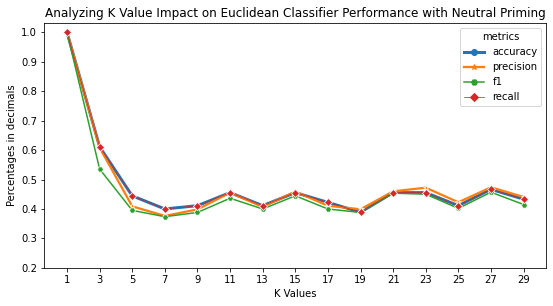

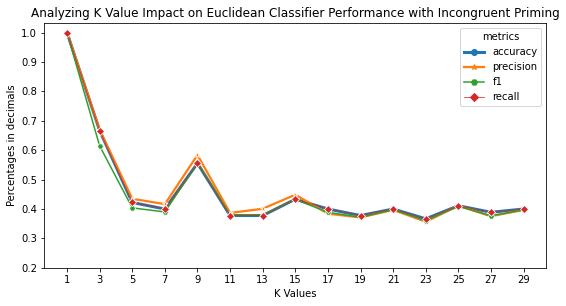

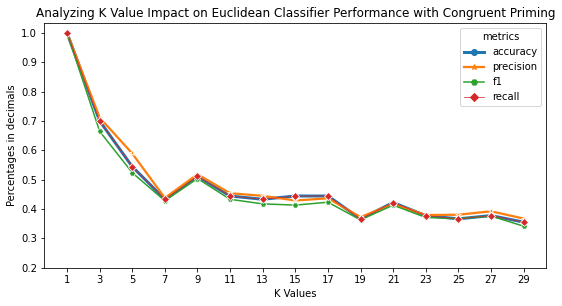

In [190]:
visualize_performance(n_df_euclid, ['accuracy', 'precision', 'f1', 'recall'], 1, ['o', '*', 'H', 'D'], 
                      'Analyzing K Value Impact on Euclidean Classifier Performance with Neutral Priming', k_list)

visualize_performance(i_df_euclid, ['accuracy', 'precision', 'f1', 'recall'], 2, ['o', '*', 'H', 'D'], 
                      'Analyzing K Value Impact on Euclidean Classifier Performance with Incongruent Priming', k_list)

visualize_performance(c_df_euclid, ['accuracy', 'precision', 'f1', 'recall'], 3, ['o', '*', 'H', 'D'], 
                      'Analyzing K Value Impact on Euclidean Classifier Performance with Congruent Priming', k_list)

In [191]:
c_df_cossim = report_dataframe(c_data, k_list, n_classes, cosine_similarity, emotions)
i_df_cossim = report_dataframe(i_data, k_list, i_classes, cosine_similarity, emotions)
n_df_cossim = report_dataframe(n_data, k_list, c_classes, cosine_similarity, emotions)

/Users/anandafrancis/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/anandafrancis/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


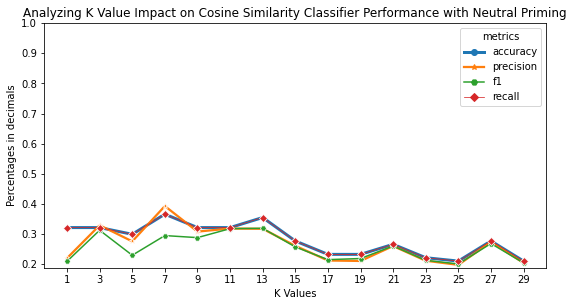

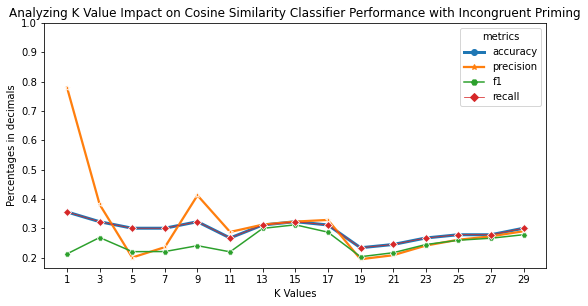

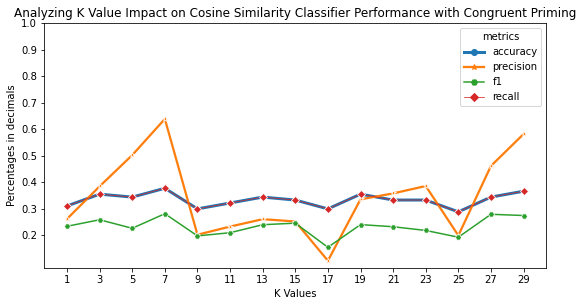

In [192]:
visualize_performance(n_df_cossim, ['accuracy', 'precision', 'f1', 'recall'], 4, ['o', '*', 'H', 'D'], 
                      'Analyzing K Value Impact on Cosine Similarity Classifier Performance with Neutral Priming', k_list)

visualize_performance(i_df_cossim, ['accuracy', 'precision', 'f1', 'recall'], 5, ['o', '*', 'H', 'D'],
                      'Analyzing K Value Impact on Cosine Similarity Classifier Performance with Incongruent Priming', k_list)

visualize_performance(c_df_cossim, ['accuracy', 'precision', 'f1', 'recall'], 6, ['o', '*', 'H', 'D'], 
                      'Analyzing K Value Impact on Cosine Similarity Classifier Performance with Congruent Priming', k_list)



0     1.000000
1     0.535509
2     0.395142
3     0.373700
4     0.388131
5     0.436362
6     0.399945
7     0.444697
8     0.399832
9     0.388021
10    0.453939
11    0.450263
12    0.401948
13    0.456926
14    0.415096
Name: f1, dtype: float64

In [193]:
# intialize
x = 6
y = 3
ylabels = ['con x euc', 'incon x euc', 'neut x euc', 'con x cos', 'incon x cos', 'neut x cos']
xlabels = emotions
simarray = np.zeros((x, y), dtype=float)

# input values in array
simarray[0,0] = c_df_euclid['anger f-1'].mean()
simarray[1,0] = i_df_euclid['anger f-1'].mean()
simarray[2,0] = n_df_euclid['anger f-1'].mean()
simarray[3,0] = c_df_cossim['anger f-1'].mean()
simarray[4,0] = i_df_cossim['anger f-1'].mean()
simarray[5,0] = n_df_cossim['anger f-1'].mean()

simarray[0,1] = c_df_euclid['disgust f-1'].mean()
simarray[1,1] = i_df_euclid['disgust f-1'].mean()
simarray[2,1] = n_df_euclid['disgust f-1'].mean()
simarray[3,1] = c_df_cossim['disgust f-1'].mean()
simarray[4,1] = i_df_cossim['disgust f-1'].mean()
simarray[5,1] = n_df_cossim['disgust f-1'].mean()

simarray[0,2] = c_df_euclid['fear f-1'].mean()
simarray[1,2] = i_df_euclid['fear f-1'].mean()
simarray[2,2] = n_df_euclid['fear f-1'].mean()
simarray[3,2] = c_df_cossim['fear f-1'].mean()
simarray[4,2] = i_df_cossim['fear f-1'].mean()
simarray[5,2] = n_df_cossim['fear f-1'].mean()

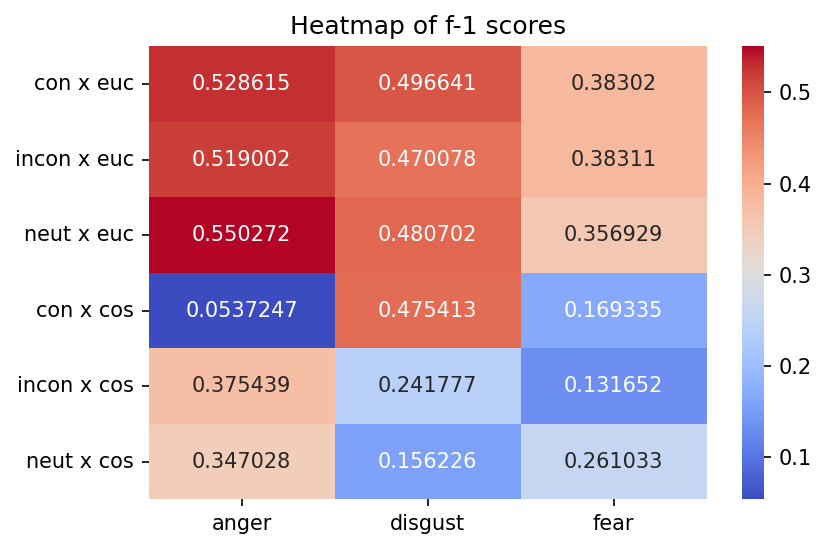

In [194]:
# plot array as heatmap 
plt.figure(dpi=150)
heat_map = sns.heatmap(simarray, cmap='coolwarm', annot=True, fmt='g')
plt.title('Heatmap of f-1 scores')
heat_map.set_xticklabels(xlabels, rotation=0) 
heat_map.set_yticklabels(ylabels, rotation=0) 
plt.show()

In [195]:
con_x_euc, incon_x_euc, neut_x_euc, con_x_cos, incon_x_cos, neut_x_cos = list(simarray.mean(axis=1))
a_f1_avg, d_f1_avg, f_f1_avg = list(simarray.mean(axis=0))

results_dict = {'anger': a_f1_avg, 'disgust' : d_f1_avg, 'fear': f_f1_avg, 'congruent': (con_x_euc + con_x_cos)/2, 
                'incongruent': (incon_x_euc + incon_x_cos)/2, 'neutral': (neut_x_euc + neut_x_cos)/2, 'euclidean': 
               (con_x_euc + incon_x_euc + neut_x_euc)/3, 'cosine similarity':(con_x_cos + incon_x_cos + neut_x_cos)/3}
results_df = pd.DataFrame({'groupings': list(results_dict.keys()), 'f-1 scores': list(results_dict.values())})

In [196]:
results_df

,groupings,f-1 scores
0,anger,0.395680
1,disgust,0.386806
2,fear,0.280846
3,congruent,0.351125
4,incongruent,0.353510
5,neutral,0.358698
6,euclidean,0.463152
7,cosine similarity,0.245736


In [201]:
def plot_correlation(emotion_roi_arr, title = None, cmap = 'coolwarm'):
    '''
    Parameters:
        emotion_roi_arr : np array
            2d array, 90 x 39, for an emotion across all participants and priming conditions
            Intensity values for each of the 39 ROIs
        
        title : str (optional; default = None)
            Title of correlation matrix
            
        cmap : str
            Color map used for heatmap
    
    Returns:
        None, just renders a correlation matrix
        showing activity of diff brain regions during emotion task
    '''
    plt.figure(dpi=150)
    correlation_measure = ConnectivityMeasure(kind='correlation')
    correlation_matrix = correlation_measure.fit_transform([emotion_roi_arr])[0]
    
    # Mask out the major diagonal
    np.fill_diagonal(correlation_matrix, 0)

    
    # Visualization: Activity of diff brain regions during emotion task
    plotting.plot_matrix(correlation_matrix, title = title, labels=msdl_atlas.labels, figure=(13,13), cmap=cmap)

In [204]:
# create 2-D array of parcellized brain data
c_p_arrays = create_brain_array(c_brain_imgs)
i_p_arrays = create_brain_array(i_brain_imgs)
n_p_arrays = create_brain_array(n_brain_imgs)

/Users/anandafrancis/opt/anaconda3/lib/python3.8/site-packages/nilearn/image/image.py:1106: FutureWarning: The parameter "sessions" will be removed in 0.9.0 release of Nilearn. Please use the parameter "runs" instead.
  data = signal.clean(
/Users/anandafrancis/opt/anaconda3/lib/python3.8/site-packages/nilearn/image/image.py:1106: FutureWarning: The parameter "sessions" will be removed in 0.9.0 release of Nilearn. Please use the parameter "runs" instead.
  data = signal.clean(
/Users/anandafrancis/opt/anaconda3/lib/python3.8/site-packages/nilearn/image/image.py:1106: FutureWarning: The parameter "sessions" will be removed in 0.9.0 release of Nilearn. Please use the parameter "runs" instead.
  data = signal.clean(


<Figure size 900x600 with 0 Axes>

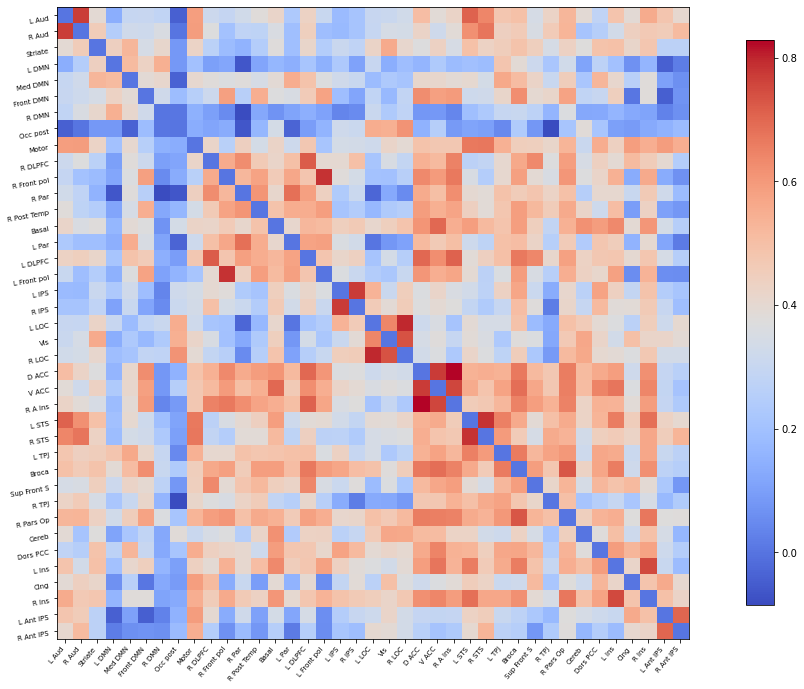

In [205]:
plot_correlation(c_p_arrays)

<Figure size 900x600 with 0 Axes>

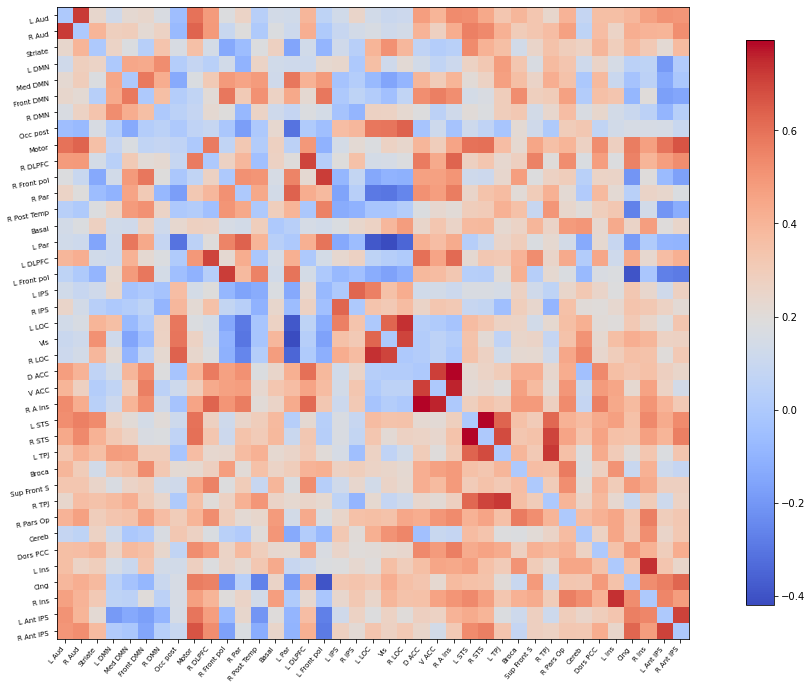

In [206]:
plot_correlation(i_p_arrays)

<Figure size 900x600 with 0 Axes>

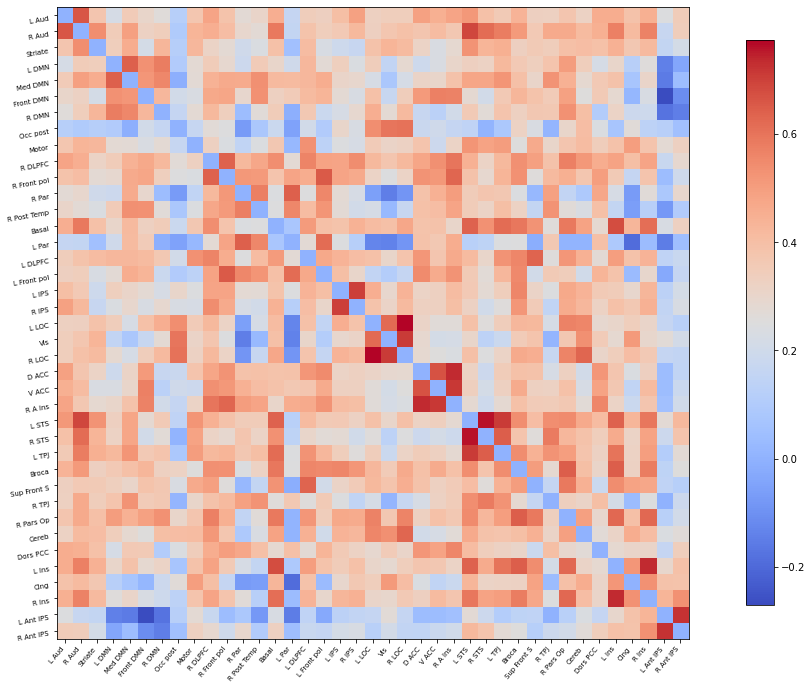

In [207]:
plot_correlation(n_p_arrays)